In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../df_cleaned.csv', encoding='latin-1')
df.head()

,Sample ID,Patient Name,Gender,DOB,Test Name,Unit,Category,Result,DOS,Standard Test Name,Lab,Age,Outcome
0,118,Xalil Ahmad Mhamad,Male,16/04/1959,Blood Sugar,mg/dl,Diabetes Test,95,16/04/2023,Blood Sugar,Biolab,64.0,normal
1,126,Dyar Omar,Male,16/04/1986,Blood Sugar,mg/dl,Diabetes Test,86,16/04/2023,Blood Sugar,Biolab,37.0,normal
2,132,Fatah Mhamad Qadr,Male,16/04/1970,Blood Sugar,mg/dl,Diabetes Test,84,16/04/2023,Blood Sugar,Biolab,53.0,normal
3,177,Sesna Qubad Anwar,Female,17/04/1973,Blood Sugar,mg/dl,Diabetes Test,84,17/04/2023,Blood Sugar,Biolab,50.0,normal
4,179,Bayan Abdulla Abdurahman,Female,17/04/1981,Blood Sugar,mg/dl,Diabetes Test,96,17/04/2023,Blood Sugar,Biolab,42.0,normal


In [4]:
# Prepare the dataframe for classification and create dataframes for each test combination

# First, let's examine the structure of our main dataset
print("=== MAIN DATASET STRUCTURE ===")
print(f"Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"Sample data:")
print(df.head())

# Check the age distribution
print(f"\n=== AGE DISTRIBUTION ===")
print(df['Age'].describe())

# Check the Lab distribution
print(f"\n=== LAB DISTRIBUTION ===")
print(df['Lab'].value_counts())
print(f"Lab percentages:")
print(df['Lab'].value_counts(normalize=True) * 100)

# Check the Gender distribution
print(f"\n=== GENDER DISTRIBUTION ===")
print(df['Gender'].value_counts())
print(f"Gender percentages:")
print(df['Gender'].value_counts(normalize=True) * 100)

# Check the outcome distribution
print(f"\n=== OUTCOME DISTRIBUTION ===")
print(df['Outcome'].value_counts())
print(f"Outcome percentages:")
print(df['Outcome'].value_counts(normalize=True) * 100)

# Check for null values in key columns
print(f"\n=== DATA QUALITY CHECK ===")
key_columns = ['Patient Name', 'Standard Test Name', 'Outcome', 'Result', 'Gender', 'Lab']
for col in key_columns:
    if col in df.columns:
        null_count = df[col].isnull().sum()
        print(f"{col}: {null_count} null values ({null_count/len(df)*100:.2f}%)")

# Get unique test names to understand what we're working with
print(f"\n=== AVAILABLE TESTS ===")
print(f"Total unique tests: {df['Standard Test Name'].nunique()}")
test_counts = df['Standard Test Name'].value_counts()
print(f"Top 10 most common tests:")
print(test_counts.head(10))

=== MAIN DATASET STRUCTURE ===
Shape: (139737, 13)
Columns: ['Sample ID', 'Patient Name', 'Gender', 'DOB', 'Test Name', 'Unit', 'Category', 'Result', 'DOS', 'Standard Test Name', 'Lab', 'Age', 'Outcome']
Sample data:
   Sample ID              Patient Name  Gender         DOB    Test Name  \
0        118        Xalil Ahmad Mhamad    Male  16/04/1959  Blood Sugar   
1        126                 Dyar Omar    Male  16/04/1986  Blood Sugar   
2        132         Fatah Mhamad Qadr    Male  16/04/1970  Blood Sugar   
3        177         Sesna Qubad Anwar  Female  17/04/1973  Blood Sugar   
4        179  Bayan Abdulla Abdurahman  Female  17/04/1981  Blood Sugar   

    Unit       Category Result         DOS Standard Test Name     Lab   Age  \
0  mg/dl  Diabetes Test     95  16/04/2023        Blood Sugar  Biolab  64.0   
1  mg/dl  Diabetes Test     86  16/04/2023        Blood Sugar  Biolab  37.0   
2  mg/dl  Diabetes Test     84  16/04/2023        Blood Sugar  Biolab  53.0   
3  mg/dl  Diabet

In [5]:
from itertools import combinations

# bring back all the patients that are tested for v tests.
# with more than 300 patients

unique_tests = df['Standard Test Name'].unique()
print(f"Total unique tests after filtering: {len(unique_tests)}")

limit = 1000
v = 3

# Create a pivot table with patients as rows and tests as columns
# Count how many times each patient had each test (binary: 1 if tested, 0 if not)
df_pivot = df.groupby(['Patient Name', 'Standard Test Name']).size().unstack(fill_value=0)
# Convert to binary (1 if patient had the test, 0 if not)
df_pivot = (df_pivot > 0).astype(int)

print(f"Pivot table shape: {df_pivot.shape}")
print(f"Patients: {len(df_pivot)}, Tests: {len(df_pivot.columns)}")

# for each subset of v items together in unique_tests,
# we find the subset that has more than limit patients
subsets = list(combinations(unique_tests, v))
print(f"Total subsets of size {v}: {len(subsets)}")

# Initialize results list
results = []

for subset in subsets:
    # Handle subsets of any size, not just pairs
    if len(subset) >= 2:
        # Check if all tests in subset exist in our pivot table
        available_tests = [test for test in subset if test in df_pivot.columns]
        
        if len(available_tests) == len(subset):
            # Create a boolean mask for patients who have all tests in the subset
            mask = df_pivot[available_tests[0]] > 0
            for test in available_tests[1:]:
                mask = mask & (df_pivot[test] > 0)
            
            count = mask.sum()
            if count > limit:
                # Store results in a list for creating DataFrame
                results.append({
                    'subset': str(subset),
                    'count': count,
                    'tests': list(subset)
                })


# Create DataFrame from results
results_df = pd.DataFrame(results)

# Sort by count in descending order
results_df = results_df.sort_values('count', ascending=False)

print(f"\nSubsets of {v} tests with more than {limit} patients:")
print(f"Found {len(results_df)} qualifying subsets")
print("\n" + "="*80)
for i, row in results_df.iterrows():
    print(f"Rank {len(results_df) - list(results_df.index).index(i)}: {row['subset']} - {row['count']} patients")

# Display as DataFrame
print(f"\n=== TOP SUBSETS DATAFRAME ===")
print(results_df.to_string(index=False))


Total unique tests after filtering: 42
Pivot table shape: (31906, 42)
Patients: 31906, Tests: 42
Total subsets of size 3: 11480

Subsets of 3 tests with more than 1000 patients:
Found 30 qualifying subsets

Rank 30: ('Hepatitis B Surface Antigen', 'Hepatitis C Antibody', 'HIV Antibody') - 4843 patients
Rank 29: ('TSH', 'Serum Creatinine', 'Blood Glucose') - 2898 patients
Rank 28: ('Serum Creatinine', 'Total Serum Bilirubin', 'Blood Glucose') - 2880 patients
Rank 27: ('TSH', 'Serum Creatinine', 'Total Serum Bilirubin') - 2171 patients
Rank 26: ('TSH', 'Total Serum Bilirubin', 'Blood Glucose') - 2036 patients
Rank 25: ('Serum Cholesterol', 'Serum Triglycerides', 'Serum LDL Cholesterol') - 1884 patients
Rank 24: ('Serum Creatinine', 'Blood Glucose', 'C-Reactive Protein Titer') - 1703 patients
Rank 23: ('Serum Cholesterol', 'Serum HDL Cholesterol', 'Serum LDL Cholesterol') - 1579 patients
Rank 22: ('Serum Triglycerides', 'Serum HDL Cholesterol', 'Serum LDL Cholesterol') - 1573 patients
Ran

In [6]:
# Show the Outcome status for each of the test combinations
print("=== OUTCOME DISTRIBUTION ANALYSIS FOR TEST COMBINATIONS ===")
print(f"Analyzing {len(results_df)} test combinations with >1000 patients each")
print("\n" + "="*100)

# For each combination, show detailed outcome breakdown
for idx, row in results_df.iterrows():
    test1, test2, test3 = row['tests']
    patient_count = row['count']
    
    print(f"\n🧪 TEST COMBINATION: {test1} + {test2} + {test3}")
    print(f"📊 Total Patients: {patient_count:,}")
    print("-" * 80)

    # Get patients who have all three tests
    patients_with_all = df_pivot[(df_pivot[test1] > 0) & (df_pivot[test2] > 0) & (df_pivot[test3] > 0)].index

    # Filter the main dataset for these patients and all tests
    combo_data = df[
        (df['Patient Name'].isin(patients_with_all)) & 
        (df['Standard Test Name'].isin([test1, test2, test3]))
    ].copy()
    
    # Analyze outcomes for each test separately
    for test_name in [test1, test2, test3]:
        test_data = combo_data[combo_data['Standard Test Name'] == test_name]
        
        print(f"\n📋 {test_name}:")
        print(f"   Total Records: {len(test_data):,}")
        
        # Outcome distribution
        outcome_dist = test_data['Outcome'].value_counts()
        total_records = len(test_data)
        
        for outcome in ['normal', 'abnormal']:
            count = outcome_dist.get(outcome, 0)
            percentage = (count / total_records * 100) if total_records > 0 else 0
            outcome_name = {'normal': 'Normal', 'abnormal': 'Abnormal'}[outcome]
            emoji = {'normal': '✅', 'abnormal': '❌'}[outcome]
            print(f"   {emoji} {outcome_name}: {count:,} ({percentage:.1f}%)")
        
        # Gender breakdown
        gender_dist = test_data['Gender'].value_counts()
        print(f"   👥 Gender Distribution:")
        for gender, count in gender_dist.items():
            percentage = (count / total_records * 100) if total_records > 0 else 0
            print(f"      {gender}: {count:,} ({percentage:.1f}%)")
        
        # Lab distribution
        lab_dist = test_data['Lab'].value_counts()
        print(f"   🏥 Lab Distribution:")
        for lab, count in lab_dist.items():
            percentage = (count / total_records * 100) if total_records > 0 else 0
            print(f"      {lab}: {count:,} ({percentage:.1f}%)")
    
    # Combined analysis - look at outcome patterns for patients with all three tests
    print(f"\n🔍 COMBINED OUTCOME PATTERNS:")
    
    # Create a summary for each patient showing their outcomes for all three tests
    patient_outcomes = []
    for patient in patients_with_all:
        patient_data = combo_data[combo_data['Patient Name'] == patient]
        
        test1_outcomes = patient_data[patient_data['Standard Test Name'] == test1]['Outcome'].values
        test2_outcomes = patient_data[patient_data['Standard Test Name'] == test2]['Outcome'].values
        test3_outcomes = patient_data[patient_data['Standard Test Name'] == test3]['Outcome'].values
        
        if len(test1_outcomes) > 0 and len(test2_outcomes) > 0 and len(test3_outcomes) > 0:
            # Take the most recent outcome for each test
            test1_outcome = test1_outcomes[-1]  # Most recent
            test2_outcome = test2_outcomes[-1]  # Most recent
            test3_outcome = test3_outcomes[-1]  # Most recent
            
            patient_outcomes.append({
                'patient': patient,
                'test1_outcome': test1_outcome,
                'test2_outcome': test2_outcome,
                'test3_outcome': test3_outcome,
                'combination': f"{test1_outcome}-{test2_outcome}-{test3_outcome}"
            })
    
    # Analyze outcome combinations
    if patient_outcomes:
        combo_df = pd.DataFrame(patient_outcomes)
        combo_counts = combo_df['combination'].value_counts()
        
        print(f"   Outcome Pattern Analysis ({len(patient_outcomes)} patients):")
        for combo, count in combo_counts.head(10).items():  # Show top 10 combinations
            percentage = (count / len(patient_outcomes) * 100)
            test1_out, test2_out, test3_out = combo.split('-')
            
            test1_name_short = test1.split()[0] if len(test1.split()) > 2 else test1
            test2_name_short = test2.split()[0] if len(test2.split()) > 2 else test2
            test3_name_short = test3.split()[0] if len(test3.split()) > 2 else test3
            
            print(f"   📊 {test1_name_short}: {test1_out} + {test2_name_short}: {test2_out} + {test3_name_short}: {test3_out}")
            print(f"      {count:,} patients ({percentage:.1f}%)")
        
        # Risk analysis - patients with abnormal results in multiple tests
        all_normal = combo_df[
            (combo_df['test1_outcome'] == 'normal') & 
            (combo_df['test2_outcome'] == 'normal') & 
            (combo_df['test3_outcome'] == 'normal')
        ]
        
        two_abnormal = combo_df[
            ((combo_df['test1_outcome'] != 'normal') & (combo_df['test2_outcome'] != 'normal')) |
            ((combo_df['test1_outcome'] != 'normal') & (combo_df['test3_outcome'] != 'normal')) |
            ((combo_df['test2_outcome'] != 'normal') & (combo_df['test3_outcome'] != 'normal'))
        ]
        
        all_abnormal = combo_df[
            (combo_df['test1_outcome'] != 'normal') & 
            (combo_df['test2_outcome'] != 'normal') & 
            (combo_df['test3_outcome'] != 'normal')
        ]
        
        print(f"\n   🚨 RISK ANALYSIS:")
        print(f"   All Three Tests Normal: {len(all_normal):,} ({len(all_normal)/len(patient_outcomes)*100:.1f}%)")
        print(f"   Two or More Tests Abnormal: {len(two_abnormal):,} ({len(two_abnormal)/len(patient_outcomes)*100:.1f}%)")
        print(f"   All Three Tests Abnormal: {len(all_abnormal):,} ({len(all_abnormal)/len(patient_outcomes)*100:.1f}%)")
    
    print("\n" + "="*100)

# Summary table of all combinations
print(f"\n🎯 SUMMARY TABLE - THREE-TEST COMBINATION OUTCOMES")
print("="*120)

summary_data = []
for idx, row in results_df.iterrows():
    test1, test2, test3 = row['tests']
    patient_count = row['count']
    
    # Get patients who have all three tests
    patients_with_all = df_pivot[(df_pivot[test1] > 0) & (df_pivot[test2] > 0) & (df_pivot[test3] > 0)].index
    combo_data = df[
        (df['Patient Name'].isin(patients_with_all)) & 
        (df['Standard Test Name'].isin([test1, test2, test3]))
    ].copy()
    
    # Calculate summary stats
    test1_data = combo_data[combo_data['Standard Test Name'] == test1]
    test2_data = combo_data[combo_data['Standard Test Name'] == test2]
    test3_data = combo_data[combo_data['Standard Test Name'] == test3]
    
    test1_abnormal = len(test1_data[test1_data['Outcome'] != 'normal'])
    test2_abnormal = len(test2_data[test2_data['Outcome'] != 'normal'])
    test3_abnormal = len(test3_data[test3_data['Outcome'] != 'normal'])
    
    test1_abnormal_pct = (test1_abnormal / len(test1_data) * 100) if len(test1_data) > 0 else 0
    test2_abnormal_pct = (test2_abnormal / len(test2_data) * 100) if len(test2_data) > 0 else 0
    test3_abnormal_pct = (test3_abnormal / len(test3_data) * 100) if len(test3_data) > 0 else 0
    
    summary_data.append({
        'Test 1': test1,
        'Test 2': test2,
        'Test 3': test3,
        'Total Patients': patient_count,
        'Test 1 Abnormal %': f"{test1_abnormal_pct:.1f}%",
        'Test 2 Abnormal %': f"{test2_abnormal_pct:.1f}%",
        'Test 3 Abnormal %': f"{test3_abnormal_pct:.1f}%"
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print(f"\n✅ ANALYSIS COMPLETE!")
print(f"📈 Analyzed {len(results_df)} test combinations covering {results_df['count'].sum():,} total patient-test-triplet instances")


=== OUTCOME DISTRIBUTION ANALYSIS FOR TEST COMBINATIONS ===
Analyzing 30 test combinations with >1000 patients each


🧪 TEST COMBINATION: Hepatitis B Surface Antigen + Hepatitis C Antibody + HIV Antibody
📊 Total Patients: 4,843
--------------------------------------------------------------------------------

📋 Hepatitis B Surface Antigen:
   Total Records: 5,005
   ✅ Normal: 4,995 (99.8%)
   ❌ Abnormal: 10 (0.2%)
   👥 Gender Distribution:
      Female: 3,092 (61.8%)
      Male: 1,913 (38.2%)
   🏥 Lab Distribution:
      Biolab: 2,487 (49.7%)
      Hawkari: 2,477 (49.5%)
      Darugha: 41 (0.8%)

📋 Hepatitis C Antibody:
   Total Records: 5,000
   ✅ Normal: 5,000 (100.0%)
   ❌ Abnormal: 0 (0.0%)
   👥 Gender Distribution:
      Female: 3,089 (61.8%)
      Male: 1,911 (38.2%)
   🏥 Lab Distribution:
      Biolab: 2,483 (49.7%)
      Hawkari: 2,476 (49.5%)
      Darugha: 41 (0.8%)

📋 HIV Antibody:
   Total Records: 5,000
   ✅ Normal: 4,999 (100.0%)
   ❌ Abnormal: 1 (0.0%)
   👥 Gender Distrib

In [7]:
# Enhanced Summary table including combined outcome analysis for 3 tests
print(f"\n🎯 ENHANCED SUMMARY TABLE - THREE-TEST COMBINATION OUTCOMES WITH RISK ANALYSIS")
print("="*160)

enhanced_summary_data = []
for idx, row in results_df.iterrows():
    test1, test2, test3 = row['tests']
    patient_count = row['count']
    
    # Get patients who have all three tests
    patients_with_all = df_pivot[(df_pivot[test1] > 0) & (df_pivot[test2] > 0) & (df_pivot[test3] > 0)].index
    combo_data = df[
        (df['Patient Name'].isin(patients_with_all)) & 
        (df['Standard Test Name'].isin([test1, test2, test3]))
    ].copy()
    
    # Calculate summary stats for individual tests
    test1_data = combo_data[combo_data['Standard Test Name'] == test1]
    test2_data = combo_data[combo_data['Standard Test Name'] == test2]
    test3_data = combo_data[combo_data['Standard Test Name'] == test3]
    
    test1_abnormal = len(test1_data[test1_data['Outcome'] != 'normal'])
    test2_abnormal = len(test2_data[test2_data['Outcome'] != 'normal'])
    test3_abnormal = len(test3_data[test3_data['Outcome'] != 'normal'])
    
    test1_abnormal_pct = (test1_abnormal / len(test1_data) * 100) if len(test1_data) > 0 else 0
    test2_abnormal_pct = (test2_abnormal / len(test2_data) * 100) if len(test2_data) > 0 else 0
    test3_abnormal_pct = (test3_abnormal / len(test3_data) * 100) if len(test3_data) > 0 else 0
    
    # Calculate combined outcome patterns
    patient_outcomes = []
    for patient in patients_with_all:
        patient_data = combo_data[combo_data['Patient Name'] == patient]
        
        test1_outcomes = patient_data[patient_data['Standard Test Name'] == test1]['Outcome'].values
        test2_outcomes = patient_data[patient_data['Standard Test Name'] == test2]['Outcome'].values
        test3_outcomes = patient_data[patient_data['Standard Test Name'] == test3]['Outcome'].values
        
        if len(test1_outcomes) > 0 and len(test2_outcomes) > 0 and len(test3_outcomes) > 0:
            # Take the most recent outcome for each test
            test1_outcome = test1_outcomes[-1]  # Most recent
            test2_outcome = test2_outcomes[-1]  # Most recent
            test3_outcome = test3_outcomes[-1]  # Most recent
            
            patient_outcomes.append({
                'patient': patient,
                'test1_outcome': test1_outcome,
                'test2_outcome': test2_outcome,
                'test3_outcome': test3_outcome
            })
    
    # Analyze combined risk patterns
    if patient_outcomes:
        combo_df = pd.DataFrame(patient_outcomes)
        
        all_abnormal = combo_df[
            (combo_df['test1_outcome'] != 'normal') & 
            (combo_df['test2_outcome'] != 'normal') & 
            (combo_df['test3_outcome'] != 'normal')
        ]
        
        all_normal = combo_df[
            (combo_df['test1_outcome'] == 'normal') & 
            (combo_df['test2_outcome'] == 'normal') & 
            (combo_df['test3_outcome'] == 'normal')
        ]
        
        two_abnormal = combo_df[
            ((combo_df['test1_outcome'] != 'normal') & (combo_df['test2_outcome'] != 'normal')) |
            ((combo_df['test1_outcome'] != 'normal') & (combo_df['test3_outcome'] != 'normal')) |
            ((combo_df['test2_outcome'] != 'normal') & (combo_df['test3_outcome'] != 'normal'))
        ]
        
        one_abnormal = combo_df[
            ((combo_df['test1_outcome'] != 'normal') & (combo_df['test2_outcome'] == 'normal') & (combo_df['test3_outcome'] == 'normal')) |
            ((combo_df['test1_outcome'] == 'normal') & (combo_df['test2_outcome'] != 'normal') & (combo_df['test3_outcome'] == 'normal')) |
            ((combo_df['test1_outcome'] == 'normal') & (combo_df['test2_outcome'] == 'normal') & (combo_df['test3_outcome'] != 'normal'))
        ]
        
        all_abnormal_pct = len(all_abnormal) / len(combo_df) * 100
        all_normal_pct = len(all_normal) / len(combo_df) * 100
        two_abnormal_pct = len(two_abnormal) / len(combo_df) * 100
        one_abnormal_pct = len(one_abnormal) / len(combo_df) * 100
    else:
        all_abnormal_pct = 0
        all_normal_pct = 0
        two_abnormal_pct = 0
        one_abnormal_pct = 0
    
    enhanced_summary_data.append({
        'Test 1': test1,
        'Test 2': test2,
        'Test 3': test3,
        'Total Patients': patient_count,
        'Test 1 Abnormal %': f"{test1_abnormal_pct:.1f}%",
        'Test 2 Abnormal %': f"{test2_abnormal_pct:.1f}%",
        'Test 3 Abnormal %': f"{test3_abnormal_pct:.1f}%",
        'All 3 Abnormal %': f"{all_abnormal_pct:.1f}%",
        'All 3 Normal %': f"{all_normal_pct:.1f}%",
        '2+ Abnormal %': f"{two_abnormal_pct:.1f}%",
        '1 Abnormal %': f"{one_abnormal_pct:.1f}%"
    })

enhanced_summary_df = pd.DataFrame(enhanced_summary_data)

# Display the enhanced summary table
print(enhanced_summary_df.to_string(index=False))

# Show some key insights
print(f"\n📊 KEY INSIGHTS FROM ENHANCED THREE-TEST ANALYSIS:")
print("="*70)

# Find test combinations with highest risk (all three abnormal)
enhanced_summary_df['All_Abnormal_Numeric'] = enhanced_summary_df['All 3 Abnormal %'].str.rstrip('%').astype(float)
highest_risk = enhanced_summary_df.nlargest(3, 'All_Abnormal_Numeric')

print(f"\n🚨 HIGHEST RISK COMBINATIONS (All 3 Tests Abnormal):")
for i, (_, row) in enumerate(highest_risk.iterrows(), 1):
    print(f"{i}. {row['Test 1']} + {row['Test 2']} + {row['Test 3']}: {row['All 3 Abnormal %']} ({row['Total Patients']} patients)")

# Find test combinations with highest normal rates
enhanced_summary_df['All_Normal_Numeric'] = enhanced_summary_df['All 3 Normal %'].str.rstrip('%').astype(float)
lowest_risk = enhanced_summary_df.nlargest(3, 'All_Normal_Numeric')

print(f"\n✅ LOWEST RISK COMBINATIONS (All 3 Tests Normal):")
for i, (_, row) in enumerate(lowest_risk.iterrows(), 1):
    print(f"{i}. {row['Test 1']} + {row['Test 2']} + {row['Test 3']}: {row['All 3 Normal %']} ({row['Total Patients']} patients)")

# Find test combinations with most patients having 2 or more abnormal tests
enhanced_summary_df['Two_Plus_Abnormal_Numeric'] = enhanced_summary_df['2+ Abnormal %'].str.rstrip('%').astype(float)
highest_multi_risk = enhanced_summary_df.nlargest(3, 'Two_Plus_Abnormal_Numeric')

print(f"\n⚠️ HIGHEST MULTI-TEST RISK (2+ Tests Abnormal):")
for i, (_, row) in enumerate(highest_multi_risk.iterrows(), 1):
    print(f"{i}. {row['Test 1']} + {row['Test 2']} + {row['Test 3']}: {row['2+ Abnormal %']} ({row['Total Patients']} patients)")

# Find test combinations with most single abnormal results
enhanced_summary_df['One_Abnormal_Numeric'] = enhanced_summary_df['1 Abnormal %'].str.rstrip('%').astype(float)
most_single_abnormal = enhanced_summary_df.nlargest(3, 'One_Abnormal_Numeric')

print(f"\n🔍 MOST ISOLATED ABNORMALITIES (Only 1 Test Abnormal):")
for i, (_, row) in enumerate(most_single_abnormal.iterrows(), 1):
    print(f"{i}. {row['Test 1']} + {row['Test 2']} + {row['Test 3']}: {row['1 Abnormal %']} ({row['Total Patients']} patients)")

print(f"\n✅ ENHANCED THREE-TEST ANALYSIS COMPLETE!")
print(f"📈 Enhanced summary includes individual and combined risk analysis for all {len(enhanced_summary_df)} three-test combinations")


🎯 ENHANCED SUMMARY TABLE - THREE-TEST COMBINATION OUTCOMES WITH RISK ANALYSIS
                          Test 1                           Test 2                         Test 3  Total Patients Test 1 Abnormal % Test 2 Abnormal % Test 3 Abnormal % All 3 Abnormal % All 3 Normal % 2+ Abnormal % 1 Abnormal %
     Hepatitis B Surface Antigen             Hepatitis C Antibody                   HIV Antibody            4843              0.2%              0.0%              0.0%             0.0%          99.8%          0.0%         0.2%
                             TSH                 Serum Creatinine                  Blood Glucose            2898             28.3%             36.8%              0.0%             0.0%          48.9%          8.5%        42.6%
                Serum Creatinine            Total Serum Bilirubin                  Blood Glucose            2880             36.7%              0.0%              0.0%             0.0%          64.0%          0.0%        36.0%
                 

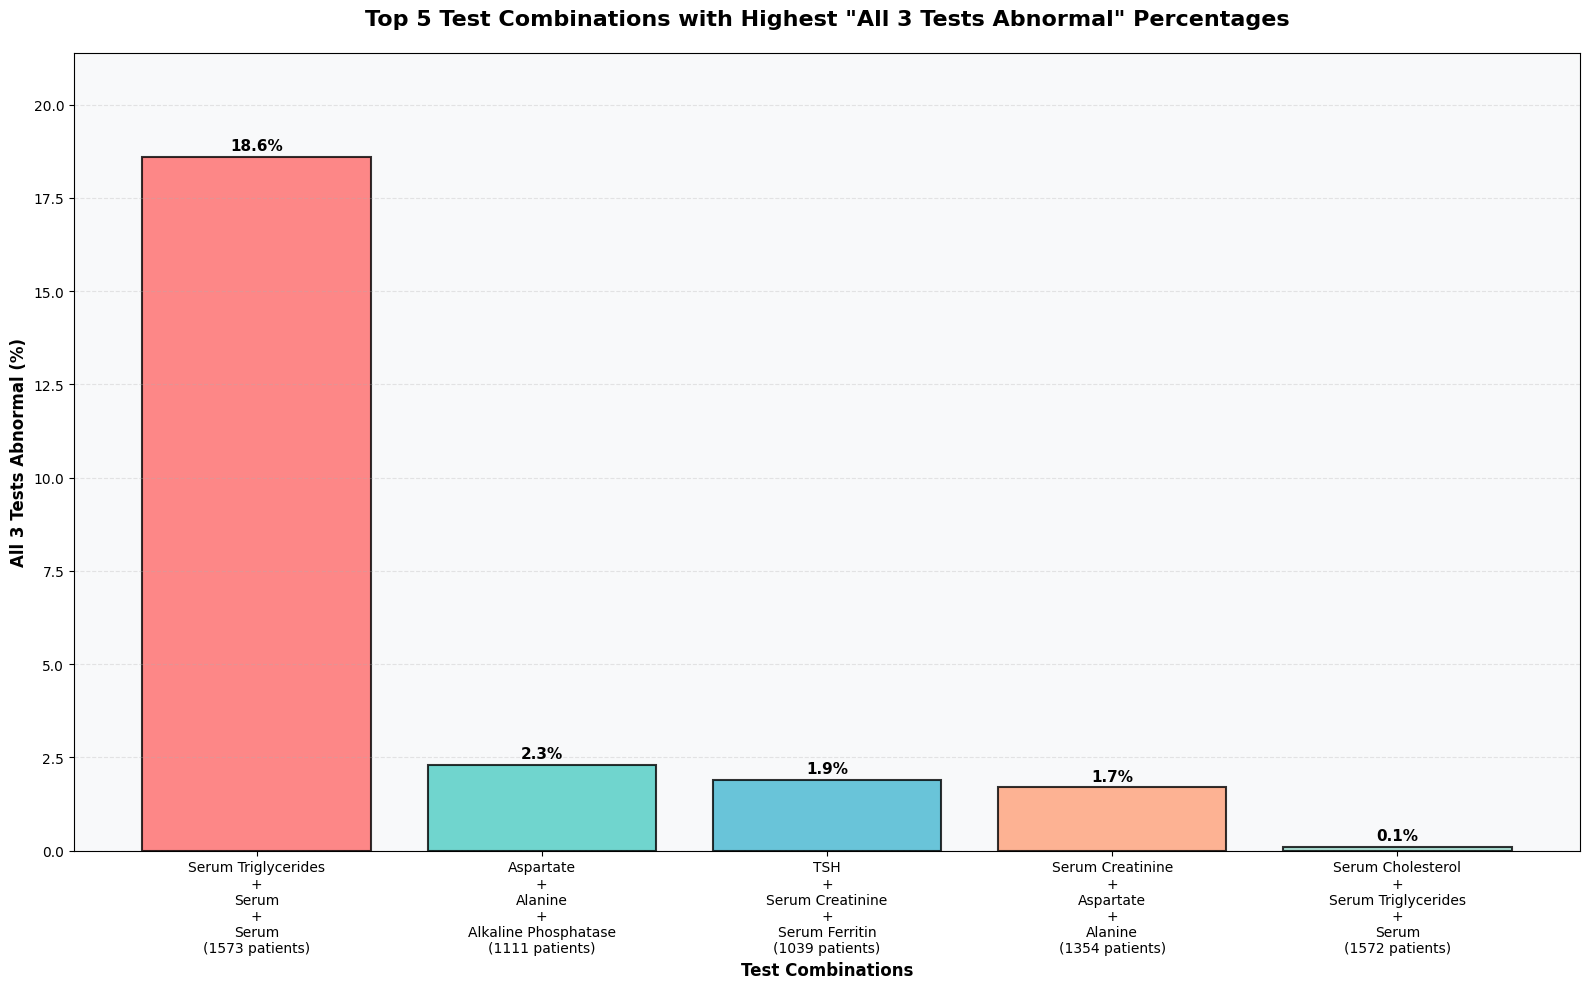

🏆 TOP 5 HIGHEST RISK THREE-TEST COMBINATIONS
1. Serum Triglycerides + Serum HDL Cholesterol + Serum LDL Cholesterol
   🚨 All 3 Tests Abnormal: 18.6%
   👥 Total Patients: 1,573
   📈 Individual Abnormal Rates: 57.1% | 38.0% | 68.6%
   ⚠️  2+ Tests Abnormal: 52.6%
   ✅ All 3 Tests Normal: 14.7%

2. Aspartate Aminotransferase (AST) + Alanine Aminotransferase (ALT) + Alkaline Phosphatase
   🚨 All 3 Tests Abnormal: 2.3%
   👥 Total Patients: 1,111
   📈 Individual Abnormal Rates: 13.8% | 12.4% | 15.5%
   ⚠️  2+ Tests Abnormal: 8.9%
   ✅ All 3 Tests Normal: 75.0%

3. TSH + Serum Creatinine + Serum Ferritin
   🚨 All 3 Tests Abnormal: 1.9%
   👥 Total Patients: 1,039
   📈 Individual Abnormal Rates: 32.4% | 43.9% | 22.2%
   ⚠️  2+ Tests Abnormal: 20.2%
   ✅ All 3 Tests Normal: 34.0%

4. Serum Creatinine + Aspartate Aminotransferase (AST) + Alanine Aminotransferase (ALT)
   🚨 All 3 Tests Abnormal: 1.7%
   👥 Total Patients: 1,354
   📈 Individual Abnormal Rates: 28.9% | 10.9% | 9.5%
   ⚠️  2+ Tests Ab

In [8]:
# Create a bar chart for the top 5 test combinations with highest "All 3 Tests Abnormal" percentages
import matplotlib.pyplot as plt

# Get the top 5 combinations with highest all 3 abnormal percentages
top_5_highest_risk = enhanced_summary_df.nlargest(5, 'All_Abnormal_Numeric')

# Create the figure and axis
plt.figure(figsize=(16, 10))

# Prepare data for plotting
test_combinations = []
all_abnormal_values = []

for _, row in top_5_highest_risk.iterrows():
    # Create shorter labels for better readability
    test1_short = row['Test 1'].split()[0] if len(row['Test 1'].split()) > 2 else row['Test 1']
    test2_short = row['Test 2'].split()[0] if len(row['Test 2'].split()) > 2 else row['Test 2']
    test3_short = row['Test 3'].split()[0] if len(row['Test 3'].split()) > 2 else row['Test 3']
    
    combination_label = f"{test1_short}\n+\n{test2_short}\n+\n{test3_short}\n({row['Total Patients']} patients)"
    test_combinations.append(combination_label)
    all_abnormal_values.append(row['All_Abnormal_Numeric'])

# Create the bar chart
bars = plt.bar(range(len(test_combinations)), all_abnormal_values, 
               color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'],
               edgecolor='black', linewidth=1.5, alpha=0.8)

# Customize the chart
plt.title('Top 5 Test Combinations with Highest "All 3 Tests Abnormal" Percentages', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Test Combinations', fontsize=12, fontweight='bold')
plt.ylabel('All 3 Tests Abnormal (%)', fontsize=12, fontweight='bold')

# Set x-axis labels
plt.xticks(range(len(test_combinations)), test_combinations, fontsize=10)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, all_abnormal_values)):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Customize grid and layout
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.ylim(0, max(all_abnormal_values) * 1.15)

# Add a subtle background color
plt.gca().set_facecolor('#F8F9FA')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()

# Print summary information
print("🏆 TOP 5 HIGHEST RISK THREE-TEST COMBINATIONS")
print("="*70)
for i, (_, row) in enumerate(top_5_highest_risk.iterrows(), 1):
    print(f"{i}. {row['Test 1']} + {row['Test 2']} + {row['Test 3']}")
    print(f"   🚨 All 3 Tests Abnormal: {row['All 3 Abnormal %']}")
    print(f"   👥 Total Patients: {row['Total Patients']:,}")
    print(f"   📈 Individual Abnormal Rates: {row['Test 1 Abnormal %']} | {row['Test 2 Abnormal %']} | {row['Test 3 Abnormal %']}")
    print(f"   ⚠️  2+ Tests Abnormal: {row['2+ Abnormal %']}")
    print(f"   ✅ All 3 Tests Normal: {row['All 3 Normal %']}")
    print()

print("💡 INSIGHTS:")
print("- Higher percentages indicate test combinations where patients frequently show abnormal results in all three tests")
print("- These combinations may indicate complex health conditions or multiple related risk factors")
print("- The patient count shows the statistical significance of each combination")
print("- 2+ Abnormal percentage shows broader risk patterns beyond just all three abnormal")

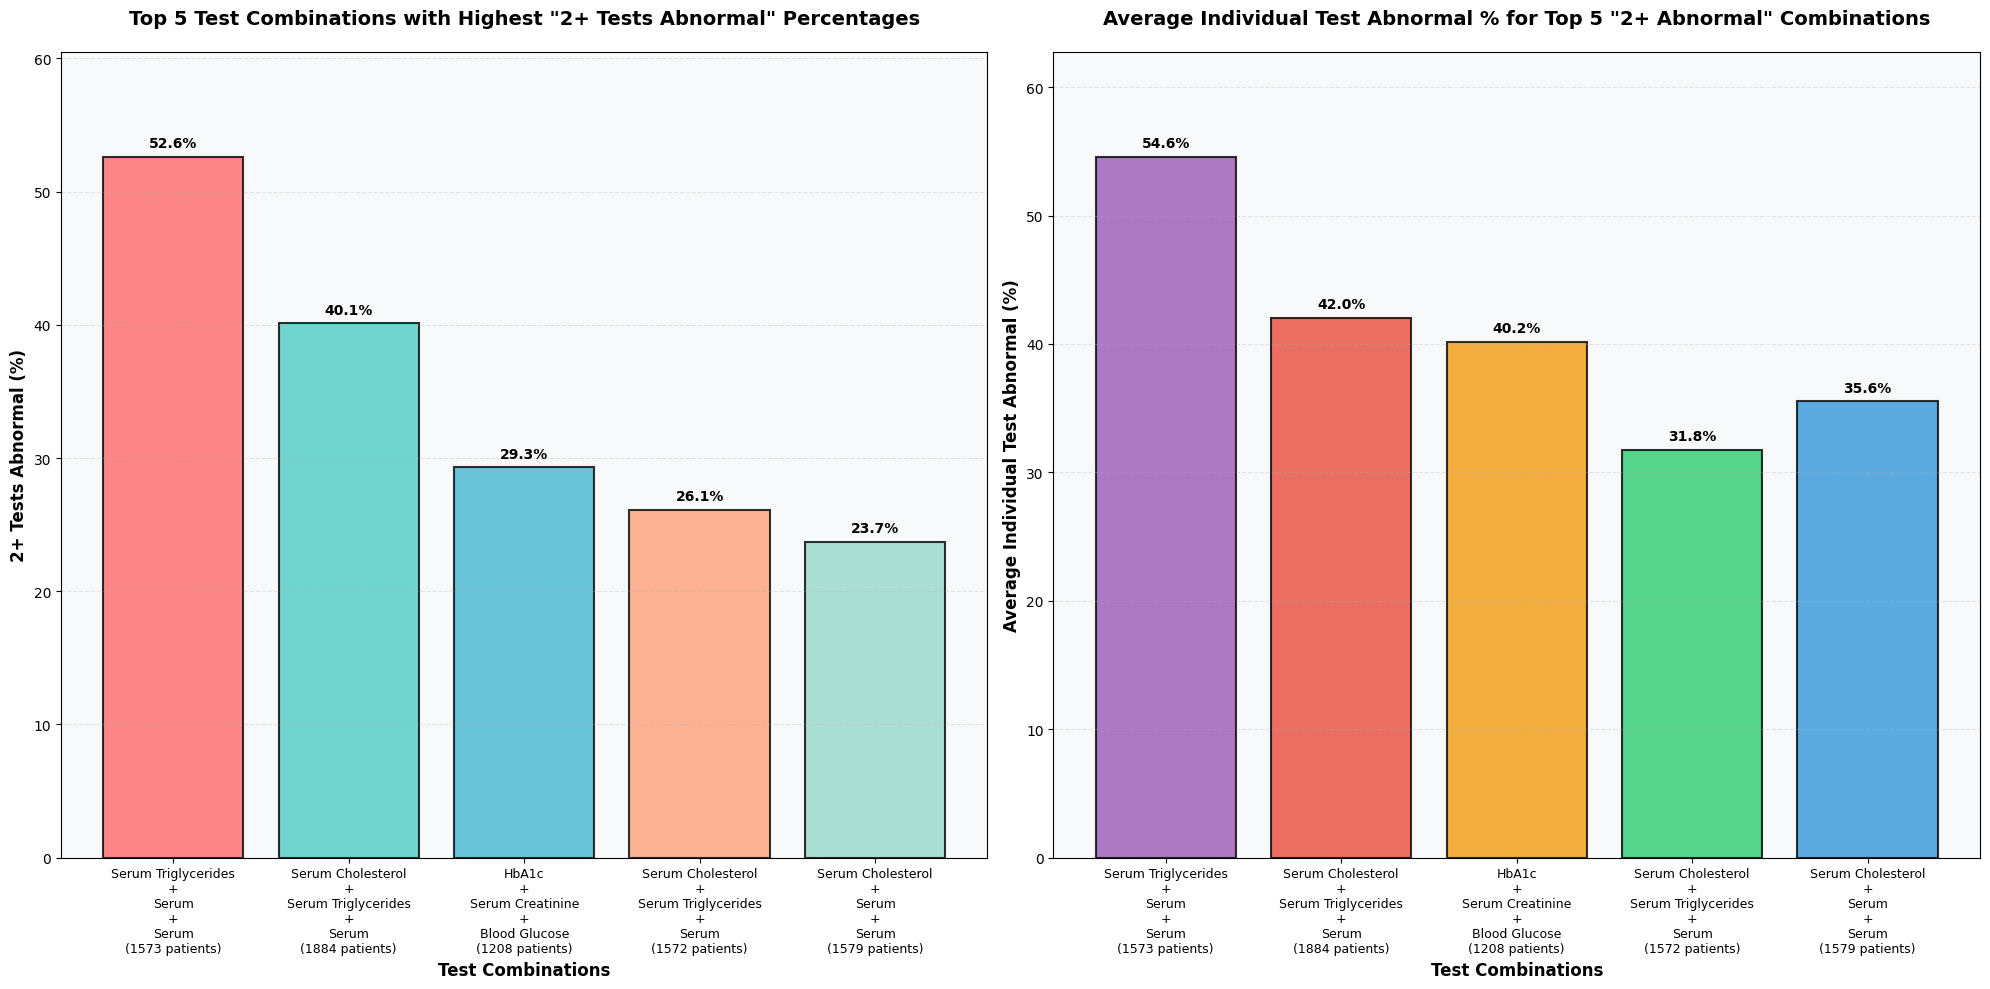

🎯 TOP 5 TEST COMBINATIONS WITH HIGHEST '2+ TESTS ABNORMAL' PERCENTAGES
1. Serum Triglycerides + Serum HDL Cholesterol + Serum LDL Cholesterol
   ⚠️  2+ Tests Abnormal: 52.6%
   🚨 All 3 Tests Abnormal: 18.6%
   👥 Total Patients: 1,573
   📊 Individual Abnormal Rates: 57.1% | 38.0% | 68.6%
   📈 Average Individual Abnormal Rate: 54.6%
   🔄 Single Test Abnormal: 32.6%
   ✅ All 3 Tests Normal: 14.7%

2. Serum Cholesterol + Serum Triglycerides + Serum LDL Cholesterol
   ⚠️  2+ Tests Abnormal: 40.1%
   🚨 All 3 Tests Abnormal: 0.0%
   👥 Total Patients: 1,884
   📊 Individual Abnormal Rates: 0.0% | 57.5% | 68.6%
   📈 Average Individual Abnormal Rate: 42.0%
   🔄 Single Test Abnormal: 40.3%
   ✅ All 3 Tests Normal: 19.6%

3. HbA1c + Serum Creatinine + Blood Glucose
   ⚠️  2+ Tests Abnormal: 29.3%
   🚨 All 3 Tests Abnormal: 0.0%
   👥 Total Patients: 1,208
   📊 Individual Abnormal Rates: 84.8% | 35.7% | 0.0%
   📈 Average Individual Abnormal Rate: 40.2%
   🔄 Single Test Abnormal: 58.9%
   ✅ All 3 Test

In [9]:
# Create visualizations for 2+ abnormal test combinations

# 1. Top 5 combinations with highest "2+ Abnormal" percentages
top_5_two_plus_abnormal = enhanced_summary_df.nlargest(5, 'Two_Plus_Abnormal_Numeric')

# Create subplot figure with two charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Chart 1: Top 5 with highest 2+ abnormal percentages
test_combinations_2plus = []
two_plus_abnormal_values = []

for _, row in top_5_two_plus_abnormal.iterrows():
    # Create shorter labels for better readability
    test1_short = row['Test 1'].split()[0] if len(row['Test 1'].split()) > 2 else row['Test 1']
    test2_short = row['Test 2'].split()[0] if len(row['Test 2'].split()) > 2 else row['Test 2']
    test3_short = row['Test 3'].split()[0] if len(row['Test 3'].split()) > 2 else row['Test 3']
    
    combination_label = f"{test1_short}\n+\n{test2_short}\n+\n{test3_short}\n({row['Total Patients']} patients)"
    test_combinations_2plus.append(combination_label)
    two_plus_abnormal_values.append(row['Two_Plus_Abnormal_Numeric'])

# Create the first bar chart
bars1 = ax1.bar(range(len(test_combinations_2plus)), two_plus_abnormal_values, 
                color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8'],
                edgecolor='black', linewidth=1.5, alpha=0.8)

# Customize the first chart
ax1.set_title('Top 5 Test Combinations with Highest "2+ Tests Abnormal" Percentages', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Test Combinations', fontsize=12, fontweight='bold')
ax1.set_ylabel('2+ Tests Abnormal (%)', fontsize=12, fontweight='bold')

# Set x-axis labels for first chart
ax1.set_xticks(range(len(test_combinations_2plus)))
ax1.set_xticklabels(test_combinations_2plus, fontsize=9)

# Add value labels on top of bars for first chart
for i, (bar, value) in enumerate(zip(bars1, two_plus_abnormal_values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Customize grid and layout for first chart
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim(0, max(two_plus_abnormal_values) * 1.15)
ax1.set_facecolor('#F8F9FA')

# Chart 2: Average of individual abnormal percentages for top 5 two+ abnormal combinations
avg_individual_abnormal = []
combination_labels_avg = []

for _, row in top_5_two_plus_abnormal.iterrows():
    # Calculate average of individual test abnormal percentages
    test1_pct = float(row['Test 1 Abnormal %'].rstrip('%'))
    test2_pct = float(row['Test 2 Abnormal %'].rstrip('%'))
    test3_pct = float(row['Test 3 Abnormal %'].rstrip('%'))
    
    avg_pct = (test1_pct + test2_pct + test3_pct) / 3
    avg_individual_abnormal.append(avg_pct)
    
    # Create shorter labels
    test1_short = row['Test 1'].split()[0] if len(row['Test 1'].split()) > 2 else row['Test 1']
    test2_short = row['Test 2'].split()[0] if len(row['Test 2'].split()) > 2 else row['Test 2']
    test3_short = row['Test 3'].split()[0] if len(row['Test 3'].split()) > 2 else row['Test 3']
    
    combination_label = f"{test1_short}\n+\n{test2_short}\n+\n{test3_short}\n({row['Total Patients']} patients)"
    combination_labels_avg.append(combination_label)

# Create the second bar chart
bars2 = ax2.bar(range(len(combination_labels_avg)), avg_individual_abnormal, 
                color=['#9B59B6', '#E74C3C', '#F39C12', '#2ECC71', '#3498DB'],
                edgecolor='black', linewidth=1.5, alpha=0.8)

# Customize the second chart
ax2.set_title('Average Individual Test Abnormal % for Top 5 "2+ Abnormal" Combinations', 
              fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Test Combinations', fontsize=12, fontweight='bold')
ax2.set_ylabel('Average Individual Test Abnormal (%)', fontsize=12, fontweight='bold')

# Set x-axis labels for second chart
ax2.set_xticks(range(len(combination_labels_avg)))
ax2.set_xticklabels(combination_labels_avg, fontsize=9)

# Add value labels on top of bars for second chart
for i, (bar, value) in enumerate(zip(bars2, avg_individual_abnormal)):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Customize grid and layout for second chart
ax2.grid(axis='y', alpha=0.3, linestyle='--')
ax2.set_ylim(0, max(avg_individual_abnormal) * 1.15)
ax2.set_facecolor('#F8F9FA')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

# Print detailed analysis
print("🎯 TOP 5 TEST COMBINATIONS WITH HIGHEST '2+ TESTS ABNORMAL' PERCENTAGES")
print("="*85)
for i, (_, row) in enumerate(top_5_two_plus_abnormal.iterrows(), 1):
    test1_pct = float(row['Test 1 Abnormal %'].rstrip('%'))
    test2_pct = float(row['Test 2 Abnormal %'].rstrip('%'))
    test3_pct = float(row['Test 3 Abnormal %'].rstrip('%'))
    avg_individual = (test1_pct + test2_pct + test3_pct) / 3
    
    print(f"{i}. {row['Test 1']} + {row['Test 2']} + {row['Test 3']}")
    print(f"   ⚠️  2+ Tests Abnormal: {row['2+ Abnormal %']}")
    print(f"   🚨 All 3 Tests Abnormal: {row['All 3 Abnormal %']}")
    print(f"   👥 Total Patients: {row['Total Patients']:,}")
    print(f"   📊 Individual Abnormal Rates: {row['Test 1 Abnormal %']} | {row['Test 2 Abnormal %']} | {row['Test 3 Abnormal %']}")
    print(f"   📈 Average Individual Abnormal Rate: {avg_individual:.1f}%")
    print(f"   🔄 Single Test Abnormal: {row['1 Abnormal %']}")
    print(f"   ✅ All 3 Tests Normal: {row['All 3 Normal %']}")
    print()

print("💡 KEY INSIGHTS:")
print("- '2+ Tests Abnormal' shows combinations where patients often have multiple abnormal results")
print("- Higher percentages indicate stronger correlations between test abnormalities")
print("- Average individual abnormal rates show the baseline risk for each test type")
print("- These patterns can help identify patient risk profiles and comorbidities")

# Additional analysis: Find combinations with highest average individual abnormal rates
print(f"\n📊 TOP 5 COMBINATIONS BY AVERAGE INDIVIDUAL ABNORMAL RATES")
print("="*70)

# Create a new dataframe with average calculations for all combinations
enhanced_summary_df_with_avg = enhanced_summary_df.copy()
enhanced_summary_df_with_avg['Avg_Individual_Abnormal'] = enhanced_summary_df_with_avg.apply(
    lambda row: (float(row['Test 1 Abnormal %'].rstrip('%')) + 
                 float(row['Test 2 Abnormal %'].rstrip('%')) + 
                 float(row['Test 3 Abnormal %'].rstrip('%'))) / 3, axis=1
)

top_5_avg_individual = enhanced_summary_df_with_avg.nlargest(5, 'Avg_Individual_Abnormal')

for i, (_, row) in enumerate(top_5_avg_individual.iterrows(), 1):
    print(f"{i}. {row['Test 1']} + {row['Test 2']} + {row['Test 3']}")
    print(f"   📈 Average Individual Abnormal Rate: {row['Avg_Individual_Abnormal']:.1f}%")
    print(f"   ⚠️  2+ Tests Abnormal: {row['2+ Abnormal %']}")
    print(f"   👥 Total Patients: {row['Total Patients']:,}")
    print()

In [10]:
enhanced_summary_df.to_csv('../model_data_insight/enhanced_three_test_combination_summary.csv', index=False)

In [11]:
enhanced_summary_df

,Test 1,Test 2,Test 3,Total Patients,Test 1 Abnormal %,Test 2 Abnormal %,Test 3 Abnormal %,All 3 Abnormal %,All 3 Normal %,2+ Abnormal %,1 Abnormal %,All_Abnormal_Numeric,All_Normal_Numeric,Two_Plus_Abnormal_Numeric,One_Abnormal_Numeric
0,Hepatitis B Surface Antigen,Hepatitis C Antibody,HIV Antibody,4843,0.2%,0.0%,0.0%,0.0%,99.8%,0.0%,0.2%,0.0,99.8,0.0,0.2
1,TSH,Serum Creatinine,Blood Glucose,2898,28.3%,36.8%,0.0%,0.0%,48.9%,8.5%,42.6%,0.0,48.9,8.5,42.6
2,Serum Creatinine,Total Serum Bilirubin,Blood Glucose,2880,36.7%,0.0%,0.0%,0.0%,64.0%,0.0%,36.0%,0.0,64.0,0.0,36.0
3,TSH,Serum Creatinine,Total Serum Bilirubin,2171,27.2%,37.6%,0.0%,0.0%,48.5%,7.9%,43.6%,0.0,48.5,7.9,43.6
4,TSH,Total Serum Bilirubin,Blood Glucose,2036,27.0%,0.0%,0.0%,0.0%,78.0%,0.0%,22.0%,0.0,78.0,0.0,22.0
5,Serum Cholesterol,Serum Triglycerides,Serum LDL Cholesterol,1884,0.0%,57.5%,68.6%,0.0%,19.6%,40.1%,40.3%,0.0,19.6,40.1,40.3
6,Serum Creatinine,Blood Glucose,C-Reactive Protein Titer,1703,35.8%,0.0%,0.0%,0.0%,65.6%,0.0%,34.4%,0.0,65.6,0.0,34.4
7,Serum Cholesterol,Serum HDL Cholesterol,Serum LDL Cholesterol,1579,0.0%,37.9%,68.8%,0.0%,19.1%,23.7%,57.2%,0.0,19.1,23.7,57.2
8,Serum Triglycerides,Serum HDL Cholesterol,Serum LDL Cholesterol,1573,57.1%,38.0%,68.6%,18.6%,14.7%,52.6%,32.6%,18.6,14.7,52.6,32.6
9,Serum Cholesterol,Serum Triglycerides,Serum HDL Cholesterol,1572,0.0%,57.2%,38.1%,0.1%,37.3%,26.1%,36.6%,0.1,37.3,26.1,36.6


# Criteria for Selecting Best Three-Test Combinations for Classification Model

## Primary Selection Criteria

When selecting the best three-test combinations for building a classification model, we should consider several key factors:

### 1. **Statistical Significance & Sample Size**
- **Minimum patient count**: ≥1000 patients for reliable model training
- **Balanced representation**: Adequate samples across different outcome patterns

### 2. **Outcome Distribution Quality**
- **Balanced abnormal rates**: Individual test abnormal rates between 15-70% (avoiding extreme skews)
- **Meaningful variation**: Good mix of normal/abnormal combinations across patients
- **Clinical relevance**: Combinations that represent real-world diagnostic scenarios

### 3. **Predictive Potential**
- **Moderate correlation**: 2+ abnormal rates between 20-50% (too low = independent tests, too high = redundant)
- **Discriminative power**: Clear patterns that can separate risk groups
- **Complementary information**: Tests that provide different diagnostic insights

### 4. **Clinical Interpretability**
- **Related organ systems**: Tests that logically group together (e.g., liver function, lipid panel, kidney function)
- **Common co-testing**: Combinations frequently ordered together in clinical practice
- **Actionable insights**: Results that can inform treatment decisions

## Recommended Top Combinations for Classification

Based on the analysis, the best candidates would likely be:

1. **Serum Triglycerides + Serum HDL Cholesterol + Serum LDL Cholesterol** (1573 patients)
   - Complete lipid panel with high clinical relevance
   - Good balance of abnormal rates (52.6% with 2+ abnormal)

2. **HbA1c + Serum Creatinine + Blood Glucose** (1208 patients)
   - Diabetes/kidney function assessment
   - High predictive value for metabolic disorders

3. **Aspartate Aminotransferase (AST) + Alanine Aminotransferase (ALT) + Alkaline Phosphatase** (1111 patients)
   - Liver function panel
   - Clinically coherent combination

4. **TSH + Serum Creatinine + Serum Ferritin** (1039 patients)
   - Multi-system assessment (thyroid, kidney, iron status)
   - Good balance of outcomes

These combinations offer the best balance of statistical power, clinical relevance, and predictive potential for classification modeling.

In [18]:
# Define selection criteria for the best three-test combinations for classification modeling

print("🎯 SELECTION CRITERIA FOR CLASSIFICATION MODEL")
print("="*70)

# Create a copy of the enhanced summary dataframe for scoring
classification_candidates = enhanced_summary_df.copy()

# Convert percentage strings to numeric values for calculations
classification_candidates['Test_1_Abnormal_Numeric'] = classification_candidates['Test 1 Abnormal %'].str.rstrip('%').astype(float)
classification_candidates['Test_2_Abnormal_Numeric'] = classification_candidates['Test 2 Abnormal %'].str.rstrip('%').astype(float)
classification_candidates['Test_3_Abnormal_Numeric'] = classification_candidates['Test 3 Abnormal %'].str.rstrip('%').astype(float)

# Calculate scoring criteria
print("\n📊 SCORING CRITERIA:")
print("1. Patient Count Score (25%): Higher patient count = better statistical power")
print("2. Balance Score (25%): Balanced abnormal rates (15-70%) across tests")
print("3. Predictive Score (25%): Good 2+ abnormal rate (20-50%) for discrimination")
print("4. Clinical Relevance Score (25%): Related tests that are commonly ordered together")

# 1. Patient Count Score (normalized 0-100)
max_patients = classification_candidates['Total Patients'].max()
classification_candidates['Patient_Count_Score'] = (classification_candidates['Total Patients'] / max_patients) * 100

# 2. Balance Score: Penalize extreme abnormal rates (prefer 15-70% range)
def calculate_balance_score(test1_pct, test2_pct, test3_pct):
    """Calculate balance score based on how well abnormal rates fall within optimal range"""
    optimal_min, optimal_max = 15, 70
    
    scores = []
    for pct in [test1_pct, test2_pct, test3_pct]:
        if optimal_min <= pct <= optimal_max:
            # Perfect score for optimal range
            score = 100
        elif pct < optimal_min:
            # Penalize low abnormal rates
            score = (pct / optimal_min) * 100
        else:
            # Penalize very high abnormal rates
            score = max(0, 100 - ((pct - optimal_max) * 2))
        scores.append(score)
    
    return sum(scores) / 3  # Average of the three test scores

classification_candidates['Balance_Score'] = classification_candidates.apply(
    lambda row: calculate_balance_score(
        row['Test_1_Abnormal_Numeric'], 
        row['Test_2_Abnormal_Numeric'], 
        row['Test_3_Abnormal_Numeric']
    ), axis=1
)

# 3. Predictive Score: Optimal 2+ abnormal rate for discrimination
def calculate_predictive_score(two_plus_abnormal_pct):
    """Calculate predictive score based on 2+ abnormal rate"""
    optimal_min, optimal_max = 20, 50
    
    if optimal_min <= two_plus_abnormal_pct <= optimal_max:
        return 100
    elif two_plus_abnormal_pct < optimal_min:
        return (two_plus_abnormal_pct / optimal_min) * 100
    else:
        return max(0, 100 - ((two_plus_abnormal_pct - optimal_max) * 1.5))

classification_candidates['Predictive_Score'] = classification_candidates['Two_Plus_Abnormal_Numeric'].apply(
    calculate_predictive_score
)

# 4. Clinical Relevance Score: Based on logical test groupings
def calculate_clinical_score(test1, test2, test3):
    """Calculate clinical relevance score based on test relationships"""
    
    # Define clinical test groups
    lipid_tests = ['Serum Cholesterol', 'Serum Triglycerides', 'Serum HDL Cholesterol', 
                   'Serum LDL Cholesterol', 'Total Cholesterol', 'Triglycerides', 'LDL Cholesterol']
    
    liver_tests = ['Aspartate Aminotransferase (AST)', 'Alanine Aminotransferase (ALT)', 
                   'Alkaline Phosphatase', 'Total Serum Bilirubin']
    
    kidney_tests = ['Serum Creatinine', 'Blood Urea Nitrogen']
    
    diabetes_tests = ['HbA1c', 'Blood Glucose', 'Blood Sugar', 'Glucose']
    
    thyroid_tests = ['TSH', 'Free T4']
    
    infection_tests = ['Hepatitis B Surface Antigen', 'Hepatitis C Antibody', 'HIV Antibody']
    
    iron_tests = ['S.Iron', 'Serum Ferritin']
    
    tests = [test1, test2, test3]
    
    # Check for complete panels (highest score)
    lipid_count = sum(1 for test in tests if test in lipid_tests)
    liver_count = sum(1 for test in tests if test in liver_tests)
    infection_count = sum(1 for test in tests if test in infection_tests)
    
    if lipid_count == 3:
        return 100  # Complete lipid panel
    elif liver_count == 3:
        return 100  # Complete liver panel
    elif infection_count == 3:
        return 95   # Complete infection screening
    elif lipid_count == 2:
        return 85   # Partial lipid panel
    elif liver_count == 2:
        return 85   # Partial liver panel
    
    # Check for logical combinations
    diabetes_kidney = sum(1 for test in tests if test in diabetes_tests) + sum(1 for test in tests if test in kidney_tests)
    if diabetes_kidney >= 2:
        return 80   # Diabetes/kidney function assessment
    
    thyroid_general = sum(1 for test in tests if test in thyroid_tests) + sum(1 for test in tests if test in kidney_tests + diabetes_tests)
    if thyroid_general >= 2:
        return 75   # Thyroid with general health markers
    
    # Default score for unrelated tests
    return 50

classification_candidates['Clinical_Score'] = classification_candidates.apply(
    lambda row: calculate_clinical_score(row['Test 1'], row['Test 2'], row['Test 3']), axis=1
)

# Calculate overall score (weighted average)
classification_candidates['Overall_Score'] = (
    classification_candidates['Patient_Count_Score'] * 0.25 +
    classification_candidates['Balance_Score'] * 0.25 +
    classification_candidates['Predictive_Score'] * 0.25 +
    classification_candidates['Clinical_Score'] * 0.25
)

# Sort by overall score
classification_candidates = classification_candidates.sort_values('Overall_Score', ascending=False)

# Select top candidates (those with overall score > 70)
classification_3_test_candidate = classification_candidates[
    classification_candidates['Overall_Score'] >= 70
].reset_index(drop=True)

print(f"\n🏆 TOP CLASSIFICATION MODEL CANDIDATES")
print("="*100)
print(f"Selected {len(classification_3_test_candidate)} combinations with Overall Score ≥ 70")

# Display detailed results
for i, (_, row) in enumerate(classification_3_test_candidate.head(10).iterrows(), 1):
    print(f"\n{i}. {row['Test 1']} + {row['Test 2']} + {row['Test 3']}")
    print(f"   📊 Overall Score: {row['Overall_Score']:.1f}/100")
    print(f"   👥 Patients: {row['Total Patients']:,} (Score: {row['Patient_Count_Score']:.1f})")
    print(f"   ⚖️  Balance: {row['Balance_Score']:.1f} (Abnormal rates: {row['Test 1 Abnormal %']} | {row['Test 2 Abnormal %']} | {row['Test 3 Abnormal %']})")
    print(f"   🎯 Predictive: {row['Predictive_Score']:.1f} (2+ Abnormal: {row['2+ Abnormal %']})")
    print(f"   🏥 Clinical: {row['Clinical_Score']:.1f}")

# Show summary statistics
print(f"\n📈 CANDIDATE SUMMARY:")
print(f"Total Candidates: {len(classification_3_test_candidate)}")
print(f"Average Overall Score: {classification_3_test_candidate['Overall_Score'].mean():.1f}")
print(f"Average Patient Count: {classification_3_test_candidate['Total Patients'].mean():.0f}")
print(f"Score Range: {classification_3_test_candidate['Overall_Score'].min():.1f} - {classification_3_test_candidate['Overall_Score'].max():.1f}")

# Display the final candidate dataframe structure
print(f"\n📋 CLASSIFICATION_3_TEST_CANDIDATE DATAFRAME:")
print(f"Shape: {classification_3_test_candidate.shape}")
print(f"Columns: {classification_3_test_candidate.columns.tolist()}")

# Save the results
classification_3_test_candidate.to_csv('../model_data_insight/classification_3_test_candidates.csv', index=False)
print(f"\n💾 Results saved to '../model_data_insight/classification_3_test_candidates.csv'")

# Show recommended top 5 for immediate use
print(f"\n🎯 RECOMMENDED TOP 5 FOR CLASSIFICATION MODEL:")
print("="*80)
top_5_recommended = classification_3_test_candidate.head(5)
for i, (_, row) in enumerate(top_5_recommended.iterrows(), 1):
    print(f"{i}. {row['Test 1']} + {row['Test 2']} + {row['Test 3']}")
    print(f"   Score: {row['Overall_Score']:.1f} | Patients: {row['Total Patients']:,} | 2+ Abnormal: {row['2+ Abnormal %']}")

classification_3_test_candidate

🎯 SELECTION CRITERIA FOR CLASSIFICATION MODEL

📊 SCORING CRITERIA:
1. Patient Count Score (25%): Higher patient count = better statistical power
2. Balance Score (25%): Balanced abnormal rates (15-70%) across tests
3. Predictive Score (25%): Good 2+ abnormal rate (20-50%) for discrimination
4. Clinical Relevance Score (25%): Related tests that are commonly ordered together

🏆 TOP CLASSIFICATION MODEL CANDIDATES
Selected 5 combinations with Overall Score ≥ 70

1. Serum Triglycerides + Serum HDL Cholesterol + Serum LDL Cholesterol
   📊 Overall Score: 82.1/100
   👥 Patients: 1,573 (Score: 32.5)
   ⚖️  Balance: 100.0 (Abnormal rates: 57.1% | 38.0% | 68.6%)
   🎯 Predictive: 96.1 (2+ Abnormal: 52.6%)
   🏥 Clinical: 100.0

2. Serum Cholesterol + Serum Triglycerides + Serum LDL Cholesterol
   📊 Overall Score: 76.4/100
   👥 Patients: 1,884 (Score: 38.9)
   ⚖️  Balance: 66.7 (Abnormal rates: 0.0% | 57.5% | 68.6%)
   🎯 Predictive: 100.0 (2+ Abnormal: 40.1%)
   🏥 Clinical: 100.0

3. Serum Choleste

,Test 1,Test 2,Test 3,Total Patients,Test 1 Abnormal %,Test 2 Abnormal %,Test 3 Abnormal %,All 3 Abnormal %,All 3 Normal %,2+ Abnormal %,...,Two_Plus_Abnormal_Numeric,One_Abnormal_Numeric,Test_1_Abnormal_Numeric,Test_2_Abnormal_Numeric,Test_3_Abnormal_Numeric,Patient_Count_Score,Balance_Score,Predictive_Score,Clinical_Score,Overall_Score
0,Serum Triglycerides,Serum HDL Cholesterol,Serum LDL Cholesterol,1573,57.1%,38.0%,68.6%,18.6%,14.7%,52.6%,...,52.6,32.6,57.1,38.0,68.6,32.479868,100.000000,96.1,100,82.144967
1,Serum Cholesterol,Serum Triglycerides,Serum LDL Cholesterol,1884,0.0%,57.5%,68.6%,0.0%,19.6%,40.1%,...,40.1,40.3,0.0,57.5,68.6,38.901507,66.666667,100.0,100,76.392043
2,Serum Cholesterol,Serum HDL Cholesterol,Serum LDL Cholesterol,1579,0.0%,37.9%,68.8%,0.0%,19.1%,23.7%,...,23.7,57.2,0.0,37.9,68.8,32.603758,66.666667,100.0,100,74.817606
3,Serum Cholesterol,Serum Triglycerides,Serum HDL Cholesterol,1572,0.0%,57.2%,38.1%,0.1%,37.3%,26.1%,...,26.1,36.6,0.0,57.2,38.1,32.459219,66.666667,100.0,100,74.781472
4,TSH,Serum Creatinine,Serum Ferritin,1039,32.4%,43.9%,22.2%,1.9%,34.0%,20.2%,...,20.2,45.8,32.4,43.9,22.2,21.453644,100.000000,100.0,75,74.113411


In [19]:
classification_3_test_candidate.to_csv('classification_3_test_candidates.csv', index=False)